# Deliverable 6.1 - Robust Tube MPC Position Controller for Landing in the z-direction only

This notebook test the robust tube MPC controller for landing in the z-direction only to robustly satisfy the position constrain under disturbances with linearized rocket system

## Key Challenge

This robust MPC controller aims to ensure that the position constraint $z\ge 0$ in the vertical direction will be satisfied at any time and under disturbances. Two cases will be simulated:
* Under random disturbances
* Under extreme disturbances


In [1]:
%load_ext autoreload
%autoreload 2

# Get parent directory and add to sys.path
import sys, os
parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)

# Require ipympl
%matplotlib widget 

In [ ]:
# MPC import
from LandMPC_template.MPCControl_z_DS import MPCControl_z
from src.rocket import Rocket
from src.pos_rocket_vis import *

# Require ipympl
%matplotlib widget 

rocket_obj_path = os.path.join(parent_dir, "Cartoon_rocket.obj")
rocket_params_path = os.path.join(parent_dir, "rocket.yaml")

## Design Procedure and Tunning Parameters
### Controller objective
The MPC controller is projected to regulate the vertical dynamic of the rocket during the landing phase. The state considered in this part is $x=[v_z, z]^T$. The objective is to move the rocket from the initial position $z=10$ to the reference $z=3$ in presence of disturbances.

To ensure robustness, the **Tube MPC** contains:
* an LQR controller to stabilize the rocket against disturbances,
* the MPC that optimizes the nominal trajectory subjected to tight constraints.

### Tuning parameter
Horizon: $H = 7.0$ s

### Dimension choice
* State: vertical velocity and position
* Input: average throttle $P_{avg}$

In [3]:
# Rocket setup
Ts  = 1/20
rocket = Rocket(Ts=Ts, model_params_filepath=rocket_params_path)
rocket.mass = 1.7 # Do not change!!!

# Visualization setup
vis = RocketVis(rocket, rocket_obj_path)
vis.anim_rate = 1

sim_time = 10.0  # simulation length in seconds
x0 = np.array([0.]*9 + [0.,0.,10.])
x_ref = np.array([0.]*9 + [1.,0.,3.])
xs, us = rocket.trim(x_ref)
print("Linearization around a steady state:")
print("x_ref = ", x_ref)
print("xs = ", xs)
print("us = ", us)
sys = rocket.linearize_sys(xs, us)
A, B = sys.A, sys.B


H = 7.0
mpc = MPCControl_z(A, B, xs, us, Ts, H)

print(f"Horizon: {H}s, Sampling time: {Ts}s, Prediction steps: {int(H/Ts)}")


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

Linearization around a steady state:
x_ref =  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 3.]
xs =  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 3.]
us =  [ 0.          0.         56.66666667  0.        ]

Constraints in delta coordinates:
  u ∈ [-16.67, 23.33]
  x[1] (z) ≥ -3.00

Ancillary controller:
  K = [-20.39369744 -28.80585866]
  Closed-loop eigenvalues: [0.90865779+0.06417572j 0.90865779-0.06417572j]
  Spectral radius: 0.9109
  RPI set complexity too high at iteration 25, stopping
  RPI set bounds: vz ± 0.00 m/s, z ± 0.52 m
  Used for tightening (5%): vz ± 0.00 m/s, z ± 0.03 m

Tightened constraints:
  X_tilde: z ≥ -2

### LQR
In order to satisfy constraint and ensure stability, we design a robust constrained control.
The tuning parameters are:
* $Q_{lqr} = diag(0.5,5.0)$
* $R_{lqr} = 0.01$

The parameters in $Q$ are set in order to ensure more weight on the vertical position z (indey 2) instead of the vertical velocity (index 1), which is less constrained. A low value for $R$ set an aggressive controller.


The gain **K** ensure stability in the closed-loop.
$$
x_{k+1} = (A+BK)x_k
$$
Stability is verified through eigenvalues of $A_{cl}$

### Disturbance model

The disturbance $w$ is set to be $w \in W := [-15, 5]$

A parameter `W_scale` is set to model the RPI

### Robust invariant set (RPI)
An initial set is given as a first estimate. 
* Too small: risk of void set
* Too large: excessive tightening

### Iterative computation of RPI
$$
E_{k+1} = (A_cl E_k ⊕ B W) ∩ E_k
$$
* Propagation of the closed-loop dynamics
* Addition of the disturbance effect
* Interesection to ensure invariance
An early stopping avoids numerical explosion

### Constraints
#### State constraints:
* $z\ge 0$
* $v_z \in [-20, 20]$
* $z \le 50$

The only strong constraint is the vertical position near the ground. The rest are set to facilitate feasibility.
#### Input constraints:
* $P_{avg} \in [40, 80]$

These are physical constraint of the throttle.

### Constraint Tightening
$$
\tilde{X} = X ⊖ E
\tilde{U} = U ⊖ K E
$$
This ensures that real state and input respect the constraints. They strongly depend on the dimension of $E$ and on the aggressivity of $K$.

In this phase, tuning is crucial:
* Large RPI $\rightarrow$ large tightening $\rightarrow$ conservative MPC
* Small RPI $\rightarrow$ more aggressive MPC but less robust

### MPC weights tuning
* $Q_{mpc} = diag(0.2,2.0)$
* $R_{mpc} = 0.001$

The terminal cost is computed with DARE to improve stability and convergence

### Tube control law
After the resolution of the MPC:
$$
u = u_{nom}+K(x-x_{nom})
$$
* MPC generates the nominal trajectory
* LQR fixes errors

### Fallback and practic robustness
In case of failure of the MPC:
* aggressive additional PD/LQR
* ensure safety and continuity


Constraints in delta coordinates:
  u ∈ [-16.67, 23.33]
  x[1] (z) ≥ -3.00

Ancillary controller:
  K = [-20.39369744 -28.80585866]
  Closed-loop eigenvalues: [0.90865779+0.06417572j 0.90865779-0.06417572j]
  Spectral radius: 0.9109


<>:38: SyntaxWarning: invalid escape sequence '\m'
<>:38: SyntaxWarning: invalid escape sequence '\m'
/var/folders/sv/t76kr7lx5wzdn3m0gsfncfjw0000gq/T/ipykernel_4773/2421340705.py:38: SyntaxWarning: invalid escape sequence '\m'
  ax1.set_title('Minimal Robust Invariant Set $\mathcal{E}$', fontsize=14)


  RPI set complexity too high at iteration 25, stopping
  RPI set bounds: vz ± 0.00 m/s, z ± 0.52 m
  Used for tightening (5%): vz ± 0.00 m/s, z ± 0.03 m

Tightened constraints:
  X_tilde: z ≥ -2.97
  U_tilde: ΔPavg ∈ [-16.29, 22.96] (range: 39.25)
  U_tilde (absolute): Pavg ∈ [40.38, 79.62]

Terminal set X_f (conservative box):
  vz ∈ [-3.00, 3.00] m/s
  z ∈ [-1.49, 1.49] m

Robust Tube MPC setup complete:
  - Horizon: 140 steps (7.0s)
  - Tightening factor: 5% (tuned for feasibility)
  - Soft constraints with penalty: 200.0
DELIVERABLE 6.1: Set Visualization
Minimal robust invariant set E:
  - Number of facets: 50
  - Number of vertices: 96

Terminal set X̃f:
  - Number of facets: 1
  - Number of vertices: 1

Vertices of tightened input constraint Ũ:
  Ũ = [-16.2917, 22.9583]


/var/folders/sv/t76kr7lx5wzdn3m0gsfncfjw0000gq/T/ipykernel_4773/2421340705.py:38: SyntaxWarning: invalid escape sequence '\m'
  ax1.set_title('Minimal Robust Invariant Set $\mathcal{E}$', fontsize=14)


NotImplementedError: Rays are not supported in matplotlib plotting.

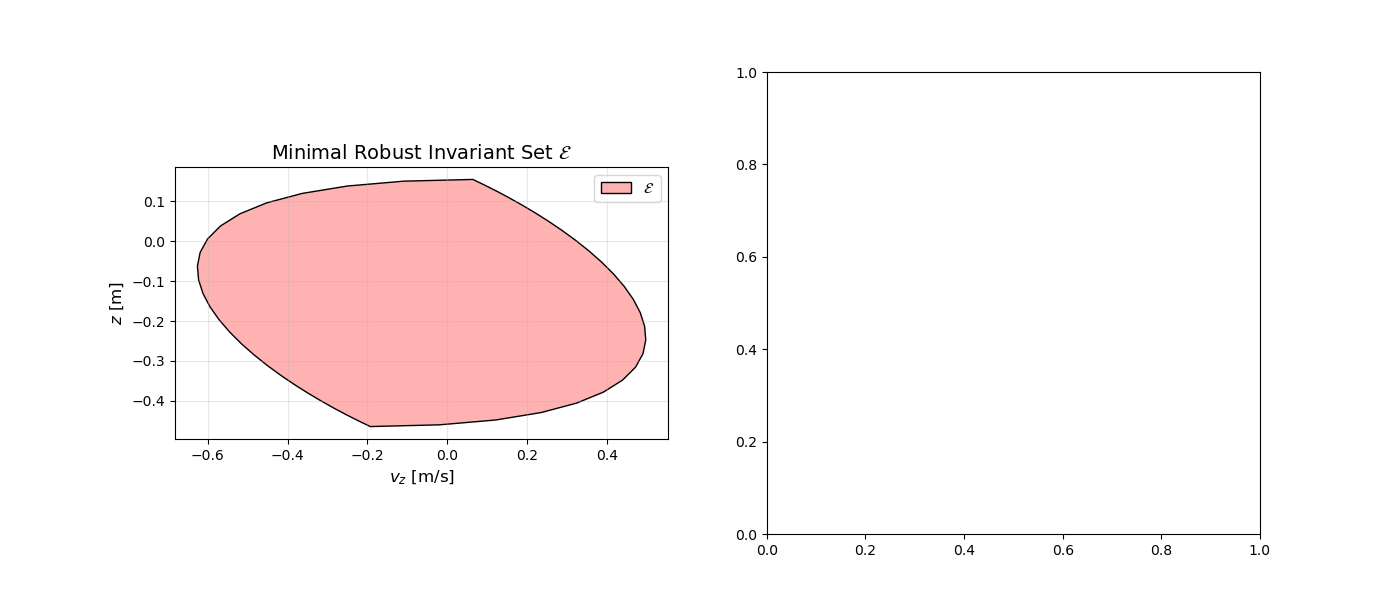

In [4]:
# Plot minimal invariant set E and terminal set X̃f

import matplotlib.pyplot as plt
import numpy as np

# Create the controller
mpc_z_rob = MPCControl_z(A, B, xs, us, Ts, H)

# Extract the computed sets
E = mpc_z_rob.E              # Minimal robust invariant set
Xf_tilde = mpc_z_rob.X_tilde  # Terminal set for tube MPC
U_tilde = mpc_z_rob.U_tilde    # Tightened input constraints

# Print set information
print("=" * 60)
print("DELIVERABLE 6.1: Set Visualization")
print("=" * 60)
print(f"Minimal robust invariant set E:")
print(f"  - Number of facets: {E.A.shape[0]}")
print(f"  - Number of vertices: {E.V.shape[0]}")

print(f"\nTerminal set X̃f:")
print(f"  - Number of facets: {Xf_tilde.A.shape[0]}")
print(f"  - Number of vertices: {Xf_tilde.V.shape[0]}")

print(f"\nVertices of tightened input constraint Ũ:")
U_tilde_vertices = U_tilde.V.flatten()
print(f"  Ũ = [{U_tilde_vertices[0]:.4f}, {U_tilde_vertices[1]:.4f}]")
print("=" * 60)

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Minimal robust invariant set E
E.plot(ax1, color='red', opacity=0.3, label=r'$\mathcal{E}$')
ax1.set_xlabel('$v_z$ [m/s]', fontsize=12)
ax1.set_ylabel('$z$ [m]', fontsize=12)
ax1.set_title('Minimal Robust Invariant Set $\mathcal{E}$', fontsize=14)
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=11)
ax1.set_aspect('equal', adjustable='box')

# Plot 2: Terminal set X̃f
Xf_tilde.plot(ax2, color='blue', opacity=0.3, label=r'$\tilde{\mathcal{X}}_f$')
ax2.set_xlabel('$v_z$ [m/s]', fontsize=12)
ax2.set_ylabel('$z$ [m]', fontsize=12)
ax2.set_title('Terminal Set $\\tilde{\\mathcal{X}}_f$', fontsize=14)
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=11)
ax2.set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.savefig('deliverable_6_1_sets.png', dpi=300, bbox_inches='tight')
plt.show()

# Additional plot: Both sets together for comparison
fig2, ax3 = plt.subplots(1, 1, figsize=(8, 6))
E.plot(ax3, color='red', opacity=0.2, label=r'$\mathcal{E}$ (RPI set)')
Xf_tilde.plot(ax3, color='blue', opacity=0.3, label=r'$\tilde{\mathcal{X}}_f$ (Terminal set)')
ax3.set_xlabel('$v_z$ [m/s]', fontsize=12)
ax3.set_ylabel('$z$ [m]', fontsize=12)
ax3.set_title('Robust MPC Sets Comparison', fontsize=14)
ax3.grid(True, alpha=0.3)
ax3.legend(fontsize=11)
ax3.set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.savefig('deliverable_6_1_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nPlots saved as 'deliverable_6_1_sets.png' and 'deliverable_6_1_comparison.png'")

## Closed-loop plots under 'random' disturbances

AppLayout(children=(HBox(children=(Play(value=0, description='Press play', max=199, step=2), IntSlider(value=0…

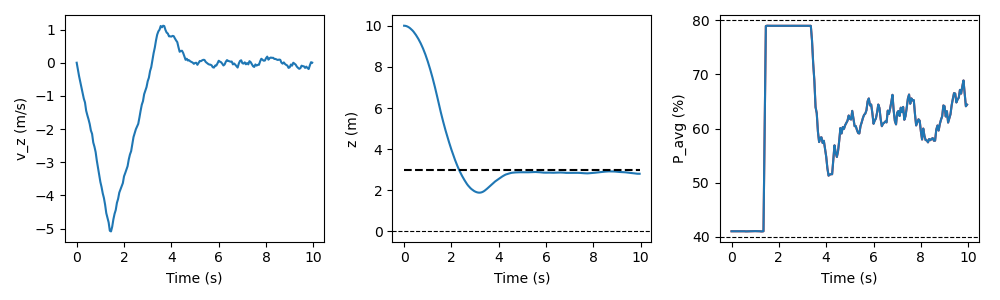

In [ ]:
t_cl, x_cl, u_cl = rocket.simulate_subsystem(mpc, sim_time, x0, w_type='random')
vis.animate(t_cl[:-1], x_cl[:,:-1], u_cl)
plot_static_states_inputs(t_cl[:-1], x_cl[:,:-1], u_cl, xs, 'sys_z')

## Closed-loop plots under 'extreme' disturbances

In [ ]:
t_cl, x_cl, u_cl = rocket.simulate_subsystem(mpc, sim_time, x0, w_type='extreme')
vis.animate(t_cl[:-1], x_cl[:,:-1], u_cl)
plot_static_states_inputs(t_cl[:-1], x_cl[:,:-1], u_cl, xs, 'sys_z')

MPC failed (infeasible), using LQR
MPC failed (infeasible), using LQR
MPC failed (infeasible), using LQR
MPC failed (infeasible), using LQR
MPC failed (infeasible), using LQR
MPC failed (infeasible), using LQR
MPC failed (infeasible), using LQR
MPC failed (infeasible), using LQR
MPC failed (infeasible), using LQR
MPC failed (infeasible), using LQR
MPC failed (infeasible), using LQR
MPC failed (infeasible), using LQR
State violation: [vz,z]=[-5.78499491 -0.18485214], [LBX, UBX]=(array([-inf,   0.]), array([inf, inf]))


ValueError: Constraints violation detected, terminating...

### Plots for Deliverable 6.1
Below: tightened sets (X~, U~) and closed-loop trajectories for random and extreme disturbances.


In [ ]:
import matplotlib.pyplot as plt

def plot_x_tilde_u_tilde(mpc):
    vz_min, z_min = mpc.x_tilde_min
    vz_max, z_max = mpc.x_tilde_max
    u_min, u_max = mpc.u_tilde_min, mpc.u_tilde_max

    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    ax[0].plot([vz_min, vz_max, vz_max, vz_min, vz_min],
               [z_min, z_min, z_max, z_max, z_min], label='X~')
    ax[0].axhline(0.0, color='k', linestyle='--', alpha=0.5, label='z=0')
    ax[0].set_xlabel('delta vz')
    ax[0].set_ylabel('delta z')
    ax[0].legend(); ax[0].grid(True)

    ax[1].plot([0,1],[u_min,u_min],'r-')
    ax[1].plot([0,1],[u_max,u_max],'r-')
    ax[1].fill_between([0,1], u_min, u_max, alpha=0.2)
    ax[1].set_ylabel('delta Pavg'); ax[1].set_xticks([]); ax[1].grid(True)
    plt.tight_layout(); plt.show()


def plot_closed_loop(t_cl, x_cl, u_cl, xs, title):
    fig, ax = plt.subplots(2,1, figsize=(10,6), sharex=True)
    ax[0].plot(t_cl, x_cl[11,:], label='z')
    ax[0].axhline(xs[1], color='k', linestyle='--', alpha=0.5, label='target z')
    ax[0].axhline(0.0, color='r', linestyle='--', alpha=0.5, label='ground')
    ax[0].set_ylabel('z [m]'); ax[0].legend(); ax[0].grid(True)

    ax[1].plot(t_cl[:-1], u_cl[2,:], label='Pavg')
    ax[1].axhline(40.0, color='r', linestyle='--', alpha=0.5)
    ax[1].axhline(80.0, color='r', linestyle='--', alpha=0.5)
    ax[1].set_ylabel('Pavg [%]'); ax[1].set_xlabel('Time [s]'); ax[1].legend(); ax[1].grid(True)
    fig.suptitle(title)
    plt.tight_layout(); plt.show()


In [ ]:
# Plot tightened sets
plot_x_tilde_u_tilde(mpc)

# Closed-loop plots (random disturbance)
plot_closed_loop(t_cl_random, x_cl_random, u_cl_random, xs, title='Closed-loop with random w in [-15,5]')

# Closed-loop plots (extreme disturbance)
plot_closed_loop(t_cl_extreme, x_cl_extreme, u_cl_extreme, xs, title='Closed-loop with w=-15 (extreme)')
